In [15]:
from yucca.modules.data.augmentation.transforms import (
    Torch_BiasField,
    Torch_Blur,
    Torch_CropPad,
    Torch_Gamma,
    Torch_MotionGhosting,
    Torch_Mask,
    Torch_GibbsRinging,
    Torch_SimulateLowres,
    Torch_Spatial,
)


from nibabel.testing import data_path
import nibabel as nib
import os
from copy import deepcopy
import numpy as np
import timeit
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Compose

np.random.seed(4215235)
iterations = 50

example_file = os.path.join(data_path, "example4d.nii.gz")
im_real = torch.tensor(nib.load(example_file).get_fdata()[:, :, :, 0], dtype=torch.float)
print(im_real.shape)

dd_real = {"image": im_real.unsqueeze(0)}
im_notreal_gpu = torch.randn((2, 256, 256, 256), dtype=torch.float).to("mps")
seg_notreal_gpu = torch.randint(0, 4, (1, 256, 256, 256), dtype=torch.int).to("mps")
dd_fake_gpu = {"image": im_notreal_gpu, "label": seg_notreal_gpu}

im_notreal_cpu = im_notreal_gpu.clone().to("cpu")
seg_notreal_cpu = seg_notreal_gpu.clone().to("cpu")
dd_fake_cpu = {"image": im_notreal_cpu, "label": seg_notreal_cpu}

torch.Size([128, 96, 24])


In [16]:
def plot(dd):
    plt.imshow(dd["image"][0, :, :, 12], cmap="gray")
    plt.show()


def test_tf(tform, real, fake_on_cpu, fake_on_gpu):
    print(
        "tform gpu: ",
        timeit.timeit(lambda: tform(deepcopy(fake_on_gpu)), number=iterations) / iterations,
        "\n ",
        "tform cpu: ",
        timeit.timeit(lambda: tform(deepcopy(fake_on_cpu)), number=iterations) / iterations,
    )

    tf_real = tf(deepcopy(real))
    plot(tf_real)

tform gpu:  0.021889914999483152 
  tform cpu:  0.10993328916025348


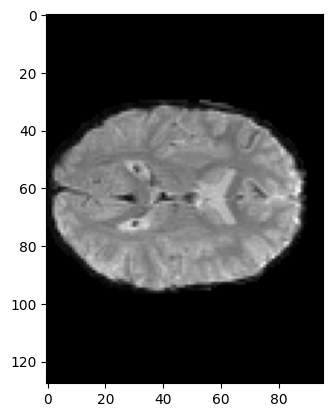

In [17]:
tf = Torch_BiasField(p_per_channel=1)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.07964389499975369 
  tform cpu:  3.568201758340001


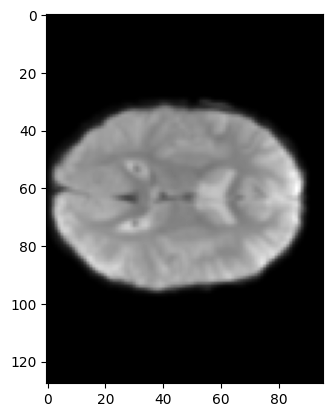

In [18]:
tf = Torch_Blur(p_per_channel=1.0)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.006219136660220102 
  tform cpu:  0.06147185665904544


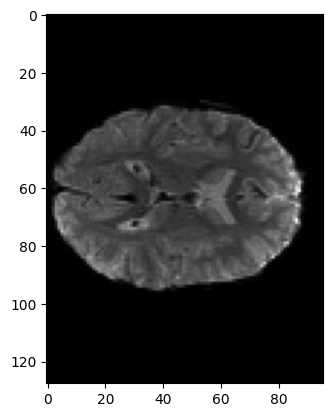

In [19]:
tf = Torch_Gamma(p_all_channel=1)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.03162736083962955 
  tform cpu:  0.6684938841802068


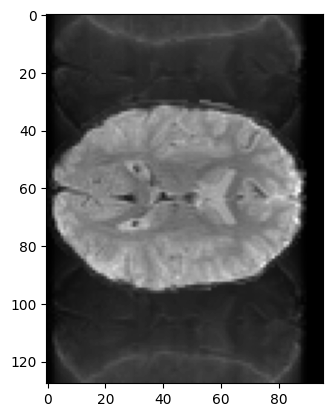

In [20]:
tf = Torch_MotionGhosting(p_per_channel=1, alpha=(2.0, 3.0), num_reps=(3, 4), axes=(0, 1))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.11687087915954181 
  tform cpu:  0.7750030308403075


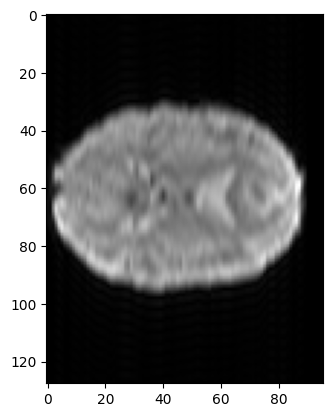

In [21]:
tf = Torch_GibbsRinging(p_per_channel=1, cut_freq=(32, 34), axes=(0, 1))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.029743109999690206 
  tform cpu:  0.025495269999373703


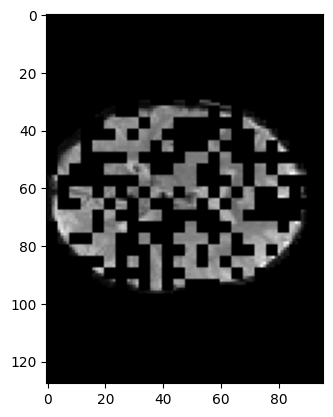

In [22]:
tf = Torch_Mask(ratio=0.5)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.058369777500629424 
  tform cpu:  0.043591927499510345


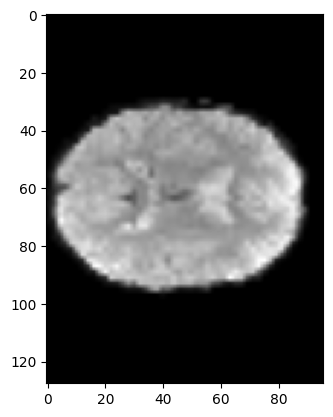

In [23]:
tf = Torch_SimulateLowres(p_per_channel=1, p_per_axis=1, zoom_range=(0.5, 0.51))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.166643888320541 
  tform cpu:  0.16093557832064107


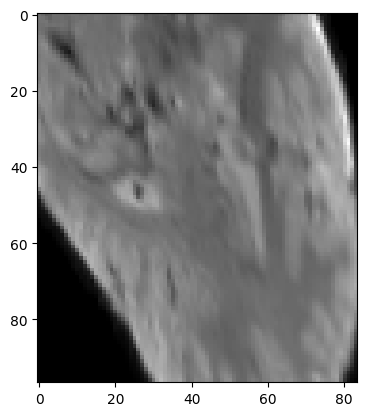

In [24]:
tf = Torch_Spatial(
    patch_size=(97, 84, 24), p_deform_all_channel=1, p_rot_all_channel=1, p_rot_per_axis=1, p_scale_all_channel=0
)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.1886279399995692 
  tform cpu:  0.8092817683401518


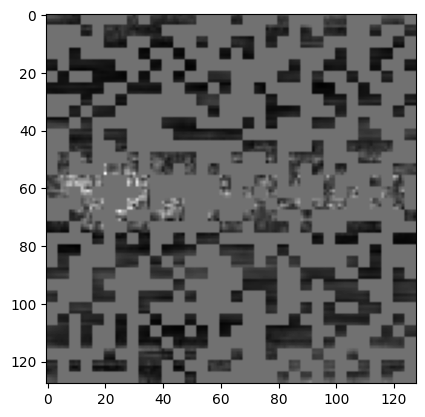

In [25]:
tf = Compose(
    [
        Torch_CropPad(patch_size=(168, 168, 168)),
        Torch_Spatial(
            patch_size=(128, 128, 128),
            p_deform_all_channel=0,
            p_rot_all_channel=1,
            p_rot_per_axis=1,
            p_scale_all_channel=1,
        ),
        Torch_BiasField(p_per_channel=1.0),
        Torch_Blur(p_per_channel=1.0),
        Torch_Gamma(p_all_channel=1),
        Torch_MotionGhosting(p_per_channel=1, alpha=(0.7, 0.8), num_reps=(2, 3), axes=(0, 1)),
        Torch_GibbsRinging(p_per_channel=1, cut_freq=(64, 68), axes=(0, 1)),
        Torch_SimulateLowres(p_per_channel=1, p_per_axis=1, zoom_range=(0.8, 0.9)),
        Torch_Mask(),
    ]
)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)